Purpose: Compare calibration of the heat balance model climate sensitivity and surface ocean mixed layer thermal inertia parameters against 1892-2017  increases in temperature over the 1650-1749 average. Then extrapolate the combined CO2, N2O, and heat balances using the calibrated heat balance parameters.

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import mpmath
from scipy.special import erf,hyp2f1
# from mpmath import erf,hyp2f1
import scipy
from scipy import log,exp,sqrt
# from mpmath import log,exp,sqrt
os.chdir('C:\\Users\\cd7\\Desktop\\Heat18Temperature')

Read the specified input file

In [2]:
df1 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat18Temperature\\heat18parameters13jan.xlsx')
df1.to_csv('heat19parameters13jan.csv',header=False,index=False)
df1 = pd.read_csv('heat19parameters13jan.csv')

df2 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat18Temperature\\heat18warming2jan200-2017.xlsx')
df2.to_csv('heat19warming2jan200-2017.csv',header=False,index=False)
df2 = pd.read_csv('heat19warming2jan200-2017.csv')

df3 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat18Temperature\\heat18fixwarming8jan200-2017.xlsx')
df3.to_csv('heat19fixwarming8jan200-2017.csv',header=False,index=False)
df3 = pd.read_csv('heat19fixwarming8jan200-2017.csv')

df4 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat17CO2\\heat17-co2-1-2017dec18.xlsx')
df4.to_csv('heat19-co2-1-2017dec18.csv',header=False,index=False)
df4 = pd.read_csv('heat19-co2-1-2017dec18.csv')

df5 = pd.read_excel('C:\\Users\\cd7\\Desktop\\Heat18_integration_coeff_table.xlsx')
print (df5)
# print (df5.iloc[0][2])

       type of integrand           a         b
0       co2_logistic_int    29.30450  2011.180
1      co2_dlogistic_int   162.81300  2003.340
2               co2_err1    19.63270  1910.940
3               co2_err2     5.56387  1932.790
4               co2_err3     9.13108  1959.730
5               co2_err4    15.21960  1993.150
6           ch4_logistic    41.38360  1973.910
7        ch4_dlogistic_1    41.38360  1973.910
8        ch4_dlogistic_2    41.38360  1973.910
9             n2o_poly_2    40.31780  2003.340
10            n2o_poly_3    40.31780  2003.340
11        n2o_1-logistic     5.08431  1956.340
12      n2o_logistic_int    40.31780  2003.340
13        Other_logistic     7.52190  1980.040
14    Contrails_logistic    17.81180  2026.340
15       Albedo_logistic    20.06400  1952.340
16    Albedo_dlogistic_1    42.94400  1893.040
17  Aerosols_dlogistic_1   162.81300  2003.340
18     Aerosols_gaussian    28.49730  2001.190
19     Ozone_dlogistic_1   162.81300  2003.340
20        Ozo

Formulate the exported file name

In [3]:
out1 = 'extrapolate';
out2 = 'co2tau';
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name)
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-')
yrs = str(int(date_split[0])-2000)
seq = [out1, yrs, out2, months[int(date_split[1])-1], date_split[2] ]
seperator = ','
filename = seperator.join(seq).replace(',', '')
print (filename)

extrapolate18co2tauoct10


Some self-defined constants

In [4]:
fix0 = 1
fix1 = 1
fixvolcano = 1
fix6 = 1.0
nave = 11
tdrop = 1551 + round(nave*((2017-1750)/nave-(2017-1750)//nave))
print (tdrop)

1554


Data
Global average temperature direct measurements as deviations from 1951-1980 mean.

In [5]:
ndrop = 1450
file2use = df2.iloc[ndrop:-1]
file2use.index = np.arange(0, len(file2use))
file3use = df3.iloc[ndrop:-1]
file3use.index = np.arange(0, len(file3use))
yrs = file2use.iloc[:,0]
temps = file2use.iloc[:,1]
fixtemps = file3use.iloc[:,1]

In [6]:
warm = df2.iloc[(ndrop+100):-1]
fixwarm = df3.iloc[(ndrop+100):-1]
warmtoave = df2.iloc[tdrop:-1]
warmtoave.index = np.arange(0, len(warmtoave))
yrstoave = warmtoave.iloc[:,0]
tempstoave = warmtoave.iloc[:,1]
mave = len(yrstoave)/nave
yrstoave = yrstoave.astype(float)
yrsave = yrstoave.groupby(np.arange(len(yrstoave))//nave).mean()
tempstoave = tempstoave.astype(float)
tempsave = tempstoave.groupby(np.arange(len(tempstoave))//nave).mean()

In [7]:
b1 = df1.iloc[:,0]
b2 = df1.iloc[:,1]
b3 = df1.iloc[:,2]
# print (b3)
b4 = df1.iloc[:,3]

tup0 = b4[25]
ch40 = b3[18]
life = b4[8]
t0 = b4[11]
tmax = b4[12]
gtonnecperppm = b4[2]

c18 = 339.873
c24 = 383.647
eps0 = 0.620523
print (gtonnecperppm)

2.13


Trial values of adjustable parameters c1, c2, and c3

In [8]:
c200 = 1.16
c220 = 0.86055
c230 = 0.24685
# c30 = 30.667*fix3
c30 = 30.667
c10 = 1*fix1
c00 = fix0  # multiplies aerosols less black carbon on snow
ctry2 = 1067.3112319440002
# c20 = ctry2*coef2
nm = [[3, 2, 4, 5, 6, 7],[9, 9, 9],[11, 11, 11, 23],[12],[13],[16,17],[14,15],[22,28],[24, 25, 26, 27],[29,30]]
# create xnm0 list
xnm0 = []
for n in range(0,len(nm)):
    sub_list=[]
    for m in range(0,len(nm[n])):
        x = (t0-b2[nm[n][m]-1])/b3[nm[n][m]-1]
        sub_list.append(float(x))
    xnm0.append(sub_list)
print (xnm0)

[[-8.912624340971526, -1.5560182540706204, -8.19754796844041, -32.85303215208119, -22.968805442510636, -15.976109753212969], [-5.410597434732601, -5.410597434732601, -5.410597434732601], [-6.283576980886852, -6.283576980886852, -6.283576980886852, -40.5836780212064], [-30.582698520320662], [-15.514434251451279], [-10.0847288676236, -3.3308494783904616], [-1.5560182540706204, -8.814519270246658], [-22.75, -34.5], [0.6649853174864708, 0.7126112909360466, -9.470909090909096, -47.9909090909091], [-1.5560182540706204, -7.0628848410577385]]


Input parameter file locations for CO2, CH4, N20, other, contrail, albedo, aerosol, volcano, and irradiance forcings, new independent variables xnm, climate sensitivity parameters, snm, and integral types inm

CO2-Industrial:

e11(annual emissions in Gtonne of CO2) is shown as logistic function,so the first general type of integrand is logistic function.
u = 1/(1 + exp(-x)), where x=(t-b2)/b3.

In [9]:
def intlogisitic(s,x,x0):
    y = exp(s*x)*(-1+ hyp2f1(1,s,1+s,-exp(x)) + s*log(1+exp(x))-s*log(1+exp(x0)))/(s**2)
    return y

def finalint1(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (-1+hyp2f1(1,s,1+s,-exp(x))-exp(s*(-x+x0))*(-1+hyp2f1(1,s,1+s,-exp(x0)))
         +s*log(1+exp(x))-s*log(1+exp(x0)))/(s**2)
#     y = (-1+hyp2f1(1,s,1+s,-x)-s*(-x+x0)*(-1+hyp2f1(1,s,1+s,-x0))
#          +s*log(1+x)-s*log(1+x0))/(s**2)
    return y

print (finalint1(2,5,2100,df5.iloc[0][1],df5.iloc[0][2],b3[nm[0][0]-1],xnm0[0][0]))
d11=b2[17]*b4[3]*b4[4]*b1[nm[0][0]-1]*b3[nm[0][0]-1]/gtonnecperppm

def tau11(coef2,fix3,t):
    y = c10*(b3[nm[0][0]-1]/(c30*fix3))*d11*finalint1(coef2,fix3,t,df5.iloc[0][1],df5.iloc[0][2],b3[nm[0][0]-1],xnm0[0][0])
    return y
print (tau11(2,5,2100))
print (tup0)

1.7216456984687145
0.5619506758771825
286.681


CO2-Land Use:

have two kinds of integrands namely: 1.the time derivative of a logistic function, 2, four gaussians functions, where gaussian function is of the form $(b1/sqrt(2*pi))*exp(-x^2/2)$.

CO2-Land Use: Logistic increase

In [10]:
def intdlogistic(s,x,x0):
    y = exp(s*x)*(1-(1+exp(x0))*hyp2f1(1,s,1+s,-exp(x)))/((1+exp(x0))*s)
    return y

def finalint2(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(exp(s*x)-exp(s*x0)-exp(s*x)*(1+exp(x0))*hyp2f1(1,s,1+s,-exp(x))
                     +exp(s*x0)*(1+exp(x0))*hyp2f1(1,s,1+s,-exp(x0)))/(s*(1+exp(x0)))
    return y

print (finalint2(2,5,2000,df5.iloc[1][1],df5.iloc[1][2],b3[nm[0][1]-1],xnm0[0][1]))

d12 = b2[17]*b4[3]*b1[nm[0][1]-1]*b4[nm[0][1]-1]/gtonnecperppm

def tau12(coef2,fix3,t):
    y = c10*(b3[nm[0][1]-1]/(c30*fix3))*d12*finalint2(coef2,fix3,t,df5.iloc[1][1],df5.iloc[1][2],b3[nm[0][1]-1],xnm0[0][1])
    return y
print (b3[nm[0][1]-1])
print (d12)
print (tau12(2,5,2000))

0.03659397151914998
162.813
1.5506248923169756
0.06025097488521093


CO2-Land Use: Erf functions

In [11]:
def interror(s,x,x0):
    y = sqrt(np.pi/2)*(exp(s*x)*erf(x/sqrt(2))-exp(s**2)*erf((-s+x)/sqrt(2))-exp(s*x)*erf(x0/sqrt(2)))/s
    return y

def finalint3(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*sqrt(np.pi/2)*(exp(s*x)*erf(x/sqrt(2))-exp(s**2/2)*erf((-s+x)/sqrt(2))-exp(s*x)*erf(x0/sqrt(2))
                                 +exp(s**2/2)*erf((-s+x0)/sqrt(2)))/s
    return y

d13 = b2[17]*b4[3]*b1[nm[0][2]-1]*b3[nm[0][2]-1]/gtonnecperppm

def tau13(coef2,fix3,t):
    y = c10*(b3[nm[0][2]-1]/(c30*fix3))*d13*finalint3(coef2,fix3,t,df5.iloc[2][1],df5.iloc[2][2],b3[nm[0][2]-1],xnm0[0][2])
    return y

print (tau13(2,5,2000))

d14 = b2[17]*b4[3]*b1[nm[0][3]-1]*b3[nm[0][3]-1]/gtonnecperppm

def tau14(coef2,fix3,t):
    y = c10*(b3[nm[0][3]-1]/(c30*fix3))*d14*finalint3(coef2,fix3,t,df5.iloc[3][1],df5.iloc[3][2],b3[nm[0][3]-1],xnm0[0][3])
    return y

print (tau14(2,5,2000))

d15 = b2[17]*b4[3]*b1[nm[0][4]-1]*b3[nm[0][4]-1]/gtonnecperppm

def tau15(coef2,fix3,t):
    y = c10*(b3[nm[0][4]-1]/(c30*fix3))*d15*finalint3(coef2,fix3,t,df5.iloc[4][1],df5.iloc[4][2],b3[nm[0][4]-1],xnm0[0][4])
    return y

d16 = b2[17]*b4[3]*b1[nm[0][5]-1]*b3[nm[0][5]-1]/gtonnecperppm

def tau16(coef2,fix3,t):
    y = c10*(b3[nm[0][5]-1]/(c30*fix3))*d16*finalint3(coef2,fix3,t,df5.iloc[5][1],df5.iloc[5][2],b3[nm[0][5]-1],xnm0[0][5])
    return y

def tau1(coef2,fix3,t):
    y = tau11(coef2,fix3,t) + tau12(coef2,fix3,t) + tau13(coef2,fix3,t) + tau14(coef2,fix3,t) + tau15(coef2,fix3,t) + tau16(coef2,fix3,t)
    return y

print (tau1(2,5,2000))

0.0033077746881360367
0.0007575933642601274
0.1470527296421471


CH4

For methane, due to its radiative forcing formula contains three terms, respectively are 1. logistic function,2. first order time derivative of logistic function, and second order time derivative of logistic function.
Let u(x) = 1/(1+exp(-x)), and up(x) = u(x)*(1-u(x)) and upp(x) = u(x)*(1-u(x))*(1-2*u(x)).

In [12]:
eps = b4[nm[1][0]-1]/b3[nm[1][0]-1]

def finalint4(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (-(exp(x + x0) + s + exp(2*x0)*s + exp(x0)* (1 + 2*s)-(1 + exp(x))*(1 + exp(x0))**2*s*hyp2f1(1,s,1 + s, -exp(x)))/(1 + exp(x))+ exp(s*(-x + x0))*(s + exp(x0)*(1 + s) - (1 + exp(x0))**2*s*hyp2f1(1, s,1 + s, -exp(x0))))/((1 + exp(x0))**2*s)
    return y

def finalint5(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(2*exp((3 + s)*x0)/((1 +exp(x0))**3*s)-2*exp(s*x + 3*x0)/((1 +exp(x0))**3*s)-(3*exp((2 + s)*x0))/((1 +exp(x0))**2*s)+(3*exp(s*x+2*x0))/((1+exp(x0))**2*s) + exp((1 + s)*x0)/(s +exp(x0)*s) - exp(s*x + x0)/(s + exp(x0)* s) + exp((1 + s)*x)*hyp2f1(1, 1 + s, 2 + s, -exp(x))/(1 + s) - exp((1 + s)*x0)*hyp2f1(1, 1 + s, 2 + s, -exp(x0))/(1 + s) -
        3*exp((2 + s)*x)*(2 + s -(1 +exp(x))*(1 + s)*hyp2f1(1, 2 + s,3 + s, -exp(x)))/((1 + exp(x))*(2 + s)) + 3*exp((2 + s)*x0)*(2 + s - (1 +exp(x0))*(1 + s)*hyp2f1(1, 2 + s,3 + s, -exp(x0)))/((1 + exp(x0))*(2 + s)) + exp((3 + s)*x)*(-(s + exp(x)*(1 + s))/((1 + exp(x))**2) + ((2 + 3*s + s**2)*hyp2f1(1, 3 + s, 4 + s, -exp(x))/(3 + s))) + exp((3 + s)*x0)*((s + exp(x0)*(1 + s))/(1 + exp(x0))**2 - ((2 + 3*s + s**2)*hyp2f1(1, 3 + s, 4 + s, -exp(x0))/(3 + s))))
    return y

d21 = b2[18]*b4[nm[1][0]-1]*b1[nm[1][0]-1]
d22 = -d21*eps
d23 = d21*eps**2

def tau21(coef2,fix3,t):
    y = c10*(b3[nm[1][0]-1]/(c30*fix3))*d21*finalint2(coef2,fix3,t,df5.iloc[6][1],df5.iloc[6][2],b3[nm[1][0]-1],xnm0[1][0])
    return y
print(tau21(2,5,2070))

def tau22(coef2,fix3,t):

    y = c10*(b3[nm[1][1]-1]/(c30*fix3))*d22*finalint4(coef2,fix3,t,df5.iloc[7][1],df5.iloc[7][2],b3[nm[1][1]-1],xnm0[1][1])
    return y
print(tau22(2,5,2200))

def tau23(coef2,fix3,t):
    y = c10*(b3[nm[1][2]-1]/(c30*fix3))*d23*finalint5(coef2,fix3,t,df5.iloc[8][1],df5.iloc[8][2],b3[nm[1][2]-1],xnm0[1][2])
    return y

print (tau23(2,5,2100))
# print(finalint5(2,5,2100,df5.iloc[6][1],df5.iloc[6][2],b3[nm[1][0]-1],xnm0[1][0]))

def tau2(coef2,fix3,t):
    y = tau21(coef2,fix3,t) + tau22(coef2,fix3,t) + tau23(coef2,fix3,t)
    return y
# print (df5.iloc[6][1],df5.iloc[6][2],b3[nm[1][0]-1],xnm0[1][0])
print (tau2(2,5,2100))

0.08808563500311804
-8.758928177700023e-05
-0.00033307923018555433
0.09328515191039007


N2O

The radiative forcing formula of nitrous oxide is shown as polylog function of order 2 and 3.

In [13]:
delta = b3[nm[2][0]-1]/b4[nm[2][0]-1]
d31 = b2[19]*b1[nm[2][0]-1]*b3[nm[2][0]-1]
d32 = d31*delta
d33 = -d31*delta**2
d34 = b2[19]*b1[nm[2][3]-1]
print (d33)
def finalint6(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (-1+ hyp2f1(1,s,1+s,-exp(x))+s*log(1+exp(x))-exp(s*(-x+x0))*(-1+hyp2f1(1,s,1+s,-exp(x0))+s*log(1+exp(x0)))+s**2*mpmath.polylog(2,-exp(x))-s**2*mpmath.polylog(2,-exp(x0)))/s**3
    return y

def finalint7(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (-1/s**4)*(-1+hyp2f1(1,s,1+s,-exp(x)) + s*log(1+exp(x))+s**2*mpmath.polylog(2,-exp(x))-exp(s*(-x+x0))*(-1+hyp2f1(1,s,1+s,-exp(x0))+s*log(1+exp(x0))+s**2*mpmath.polylog(2,-exp(x0)))-s**3*mpmath.polylog(3,-exp(x))+s**3*mpmath.polylog(3,-exp(x0)))
    return y

def finalint8(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (hyp2f1(1, s, 1 + s, -exp(x)) - exp(s*(-x + x0))*hyp2f1(1, s, 1 + s, -exp(x0)))/s
    return y

def tau32(coef2,fix3,t):
    y = c10*(b3[nm[2][1]-1]/(c30*fix3))*d32*finalint6(coef2,fix3,t,df5.iloc[9][1],df5.iloc[9][2],b3[nm[2][1]-1],xnm0[2][1])
    return y

def tau33(coef2,fix3,t):
    y = c10*(b3[nm[2][2]-1]/(c30*fix3))*d33*finalint7(coef2,fix3,t,df5.iloc[10][1],df5.iloc[10][2],b3[nm[2][2]-1],xnm0[2][2])
    return y

def tau31(coef2,fix3,t):
    y = c10*(b3[nm[2][0]-1]/(c30*fix3))*d31*finalint1(coef2,fix3,t,df5.iloc[12][1],df5.iloc[12][2],b3[nm[2][0]-1],xnm0[2][0])
    return y

def tau34(coef2,fix3,t):
    y = c10*(b3[nm[2][3]-1]/(c30*fix3))*d34*finalint8(coef2,fix3,t,df5.iloc[11][1],df5.iloc[11][2],b3[nm[2][3]-1],xnm0[2][3])
    return y

def tau3(coef2,fix3,t):
#     y = tau31(coef2,fix3,t) + tau32(coef2,fix3,t) +tau33(coef2,fix3,t) +tau34(coef2,fix3,t)
    y = tau31(coef2,fix3,t) +tau34(coef2,fix3,t)
    return y

# print (xnm0[2][3])
print (tau3(2,5,2100))

-0.029269807950403664
0.08102672029566713


Other well mixed greenhouse gases radiative forcing formula contains a logistic function.

In [14]:
def finalint41(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (exp(-s*x)*(exp((1 + s)*x)*hyp2f1(1, 1 + s, 2 + s, -exp(x))-exp((1 + s)*x0)*hyp2f1(1, 1 + s, 2 + s, -exp(x0))))/(1 + s)
    return y

d41 = b1[nm[3][0]-1]

def tau4(coef2,fix3,t):
    y = c10*(b3[nm[3][0]-1]/(c30*fix3))*d41*finalint41(coef2,fix3,t,df5.iloc[13][1],df5.iloc[13][2],b3[nm[3][0]-1],xnm0[3][0])
    return y

print (tau4(2,5,2100))
print (d41)

0.04825742214543138
0.360664


Contrails radiative forcing formula contains a logistic function.

In [15]:
d51 = b1[nm[4][0]-1]
def tau5(coef2,fix3,t):
    y = c10*(b3[nm[3][0]-1]/(c30*fix3))*d51*finalint41(coef2,fix3,t,df5.iloc[14][1],df5.iloc[14][2],b3[nm[4][0]-1],xnm0[4][0])
    return y

print (tau5(2,5,2100))
print ((b3[nm[4][0]-1])*ctry2/(c30*tup0))

0.008800859361801753
2.1623634198059896


Land use albedo change shielding radiative forcing formula contain a logistic function and a constant times the first order time derivative of the unit logistic function.

In [16]:
d61 = b1[nm[5][0]-1]
d62 = b1[nm[5][1]-1]/b3[nm[5][1]-1]

def finalint62(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(exp((1 + s)*x)*(1/(1 + exp(x))-s*hyp2f1(1, 1 + s, 2 + s, -exp(x))/(1 + s))+exp((1 + s)*x0)*(-1/(1 +exp(x0)) + s*hyp2f1(1, 1 + s, 2+s, -exp(x0))/(1 + s)))
    return y

def tau61(coef2,fix3,t):
    y = (b3[nm[5][0]-1]/(c30*fix3))*d61*finalint41(coef2,fix3,t,df5.iloc[15][1],df5.iloc[15][2],b3[nm[5][0]-1],xnm0[5][0])
    return y

def tau62(coef2,fix3,t):
    y = (b3[nm[5][1]-1]/(c30*fix3))*d62*finalint62(coef2,fix3,t,df5.iloc[16][1],df5.iloc[16][2],b3[nm[5][1]-1],xnm0[5][1])
    return y

def tau6(coef2,fix3,t):
    y = tau61(coef2,fix3,t)+tau62(coef2,fix3,t)
    return y

print (tau6(2,5,2100))
# print (finalint62(2,5,2100,df5.iloc[16][1],df5.iloc[16][2],b3[nm[5][1]-1],xnm0[5][1]))
# print (d62)

0.0201237652650039


Anthropogenic aerosols and black carbon on snow net shielding

In this case, radiative forcing formula contain a first order time derivative of a unit logistic function, and a gaussian function.

In [17]:
# d71 = fix5*b4[nm[6][0]-1]*b1[nm[6][0]-1]/b3[nm[6][0]-1]

def d71(fix5):
    y = fix5*b4[nm[6][0]-1]*b1[nm[6][0]-1]/b3[nm[6][0]-1]
    return y

d72 = fix6*b1[nm[6][1]-1]

def finalint72(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(1/2*s*(s-2*x))*sqrt(np.pi/2)*(erf((-s + x)/sqrt(2))-erf((-s + x0)/sqrt(2)))
    return y

def tau71(coef2,fix5,fix3,t):
    y = c00*(b3[nm[6][0]-1]/(c30*fix3))*d71(fix5)*finalint4(coef2,fix3,t,df5.iloc[17][1],df5.iloc[17][2],b3[nm[6][0]-1],xnm0[6][0])
    return y

def tau72(coef2,fix3,t):
    y = c00*(b3[nm[6][1]-1]/(c30*fix3))*d72*finalint72(coef2,fix3,t,df5.iloc[18][1],df5.iloc[18][2],b3[nm[6][1]-1],xnm0[6][1])
    return y

def tau7(coef2,fix3,fix5,t):
    y = tau71(coef2,fix5,fix3,t)+tau72(coef2,fix3,t)
    return y
print (tau7(2,5,3,2100))

0.10984147461109102


Tropospheric Ozone Forcing

In this case, radiative forcing formula contain a first order time derivative of a unit logistic function, and a gaussian function.

In [18]:
d101 = b4[nm[9][0]-1]*b1[nm[9][0]-1]/b3[nm[9][0]-1]
d102 = b1[nm[9][1]-1]

def tau101(coef2,fix3,t):
    y = c10*(b3[nm[6][0]-1]/(c30*fix3))*d101*finalint4(coef2,fix3,t,df5.iloc[19][1],df5.iloc[19][2],b3[nm[6][0]-1],xnm0[6][0])
    return y

def tau102(coef2,fix3,t):
    y = c10*(b3[nm[9][1]-1]/(c30*fix3))*d102*finalint72(coef2,fix3,t,df5.iloc[20][1],df5.iloc[20][2],b3[nm[9][1]-1],xnm0[9][1])
    return y

def tau10(coef2,fix3,t):
    y = tau101(coef2,fix3,t) + tau102(coef2,fix3,t)
    return y
print (tau10(2,5,2100))
print (xnm0[6][0])

0.01894799033194046
-1.5560182540706204


Volcanic shielding

In this case, radiative forcing formula contain a unit logistic function, and a (1-unit logistic function).

In [28]:
d81 = b1[nm[7][0]-1]
d82 = b1[nm[7][1]-1]
d83 = -b1[nm[7][1]-1]
d84 = b4[nm[7][1]-1]
print (d84)

def finalint81(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = (hyp2f1(1, s, 1 + s, -exp(x)) - exp(s*(-x + x0))*hyp2f1(1, s, 1 + s, -exp(x0)))/s
    return y

def finalint82(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(exp((1 + s)*x)*hyp2f1(1, 1 + s, 2 + s, -exp(x))-exp((1 + s)*x0)*hyp2f1(1, 1 + s, 2 + s, -exp(x0)))/(1 + s)
    return y

def tau81(coef2,fix3,t):
    y = (b3[nm[7][0]-1]/(c30*fix3))*d81*finalint81(coef2,fix3,t,df5.iloc[21][1],df5.iloc[21][2],b3[nm[7][0]-1],xnm0[7][0])
    return y
def tau82(coef2,fix3,t):
    y = (b3[nm[7][0]-1]/(c30*fix3))*d82*finalint82(coef2,fix3,t,df5.iloc[22][1],df5.iloc[22][2],b3[nm[7][0]-1],xnm0[7][0])
    return y
def tau83(coef2,fix3,t):
    y = (b3[nm[7][1]-1]/(c30*fix3))*d83*finalint82(coef2,fix3,t,df5.iloc[23][1],df5.iloc[23][2],b3[nm[7][1]-1],xnm0[7][1])
    return y
def tau84(coef2,fix3,t):
    y = (b3[nm[7][1]-1]/(c30*fix3))*d84*finalint82(coef2,fix3,t,df5.iloc[23][1],df5.iloc[23][2],b3[nm[7][1]-1],xnm0[7][1])
    return y
def tau8(coef2,fix3,t):
    y = tau81(coef2,fix3,t)+tau82(coef2,fix3,t) +tau83(coef2,fix3,t) +tau84(coef2,fix3,t) 
    return y

print (tau84(2,5,2100))
print(df5.iloc[22][2])
print (df5.iloc[23][2])
print (((b3[nm[7][1]-1])*ctry2)/(c30*tup0))

0.183586
0.024655673585996317
1795.5
1819.0
0.24280122388596204


Irradiance variation forcing

In this case, radiative forcing formula contain a cosine function and a gaussian function.

In [20]:
d91 = b1[nm[8][0]-1]
d92 = b1[nm[8][1]-1]
d93 = -b1[nm[8][2]-1]
d94 = b1[nm[8][3]-1]
d95 = b4[nm[8][1]-1]

def finalint9(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = exp(-s*x)*(exp(s*x)*s*np.cos(2*np.pi*x)-exp(s*x0)*s*np.cos(2*np.pi*x0)+2*exp(s*x)*np.pi*np.sin(2*np.pi*x)-2*exp(s*x0)*np.pi *np.sin(2*np.pi*x0))/(4*np.pi**2 + s**2)
    return y

def finalint95(coef2,fix3,t,a,b,c,x0):
    x = (-b+t)/a
    s = (c*ctry2*coef2)/(c30*fix3*tup0)
    y = -(-1 + exp(s*(-x + x0)))/s
    return y

def tau91(coef2,fix3,t):
    y = (b3[nm[8][0]-1]/(c30*fix3))*d91*finalint9(coef2,fix3,t,df5.iloc[25][1],df5.iloc[25][2],b3[nm[8][0]-1],xnm0[8][0])
    return y

def tau92(coef2,fix3,t):
    y = (b3[nm[8][1]-1]/(c30*fix3))*d92*finalint9(coef2,fix3,t,df5.iloc[24][1],df5.iloc[24][2],b3[nm[8][1]-1],xnm0[8][1])
    return y

def tau93(coef2,fix3,t):
    y = (b3[nm[8][2]-1]/(c30*fix3))*d93*finalint72(coef2,fix3,t,df5.iloc[26][1],df5.iloc[26][2],b3[nm[8][2]-1],xnm0[8][2])
    return y

def tau94(coef2,fix3,t):
    y = (b3[nm[8][3]-1]/(c30*fix3))*d94*finalint72(coef2,fix3,t,df5.iloc[27][1],df5.iloc[27][2],b3[nm[8][3]-1],xnm0[8][3])
    return y

def tau95(coef2,fix3,t):
    y = (b3[nm[8][1]-1]/(c30*fix3))*d95*finalint95(coef2,fix3,t,df5.iloc[28][1],df5.iloc[28][2],b3[nm[8][1]-1],xnm0[8][1])
    return y

def tau9(coef2,fix3,t):
    y = tau91(coef2,fix3,t) + tau92(coef2,fix3,t) + tau93(coef2,fix3,t) + tau94(coef2,fix3,t) + tau95(coef2,fix3,t)
    return y
print (xnm0)
print (tau9(2,5,2100))
print (df5.iloc[26][1])

[[-8.912624340971526, -1.5560182540706204, -8.19754796844041, -32.85303215208119, -22.968805442510636, -15.976109753212969], [-5.410597434732601, -5.410597434732601, -5.410597434732601], [-6.283576980886852, -6.283576980886852, -6.283576980886852, -40.5836780212064], [-30.582698520320662], [-15.514434251451279], [-10.0847288676236, -3.3308494783904616], [-1.5560182540706204, -8.814519270246658], [-22.75, -34.5], [0.6649853174864708, 0.7126112909360466, -9.470909090909096, -47.9909090909091], [-1.5560182540706204, -7.0628848410577385]]
0.04236964782934066
11.0


Total tau

[0.32206526 1.6396756  1.60519106]


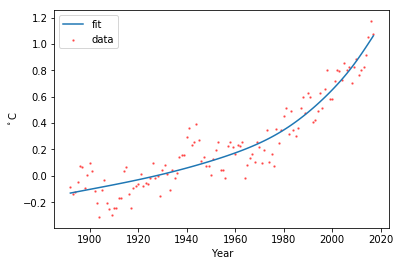

0.8339959569968821
50.28393177006672
1.605191059304625


In [21]:
tstart = 1892
yrswarm = warm.iloc[:,0]
yrswarm = yrswarm.tolist()
yrswarm = list(map(int, yrswarm))

tempswarm = warm.iloc[:,1]
tempswarm = tempswarm.tolist()
tempswarm = list(map(float, tempswarm))

istart = yrswarm.index(tstart)
# print (yrswarm)
# print (istart)
yrswarmi = yrswarm[istart:]
tempswarmi = tempswarm[istart:]
fixtemps = fixwarm.iloc[:,1]
# print (yrswarmi)
# print(tempswarmi)

# yrswarmi = np.array(yrswarmi, dtype=np.float32)
# tempswarmi = np.array(tempswarmi, dtype=np.float32)

# taui = tau /. t -> yrswarm
# err1 = Drop[(tempswarm - taui), istart - 1]
# fixerr1 = (fixtemps - taui)
# var = err1.err1
# fixvar = fixerr1.fixerr1

def tau(t,coef2,fix3,fix5):
# def tau(t,coef2,fix3):
    y = tau1(coef2,fix3,t) + tau2(coef2,fix3,t) + tau3(coef2,fix3,t) + tau4(coef2,fix3,t) + tau5(coef2,fix3,t) - tau6(coef2,fix3,t) - tau7(coef2,fix3,fix5,t) - tau8(coef2,fix3,t) + tau9(coef2,fix3,t) + tau10(coef2,fix3,t)
#     y = tau1(t,coef2,fix3) + tau2(t,coef2,fix3) + tau3(t,coef2,fix3) + tau4(t,coef2,fix3) + tau5(t,coef2,fix3) - tau6(t,coef2,fix3) - tau7(t,coef2,fix3,fix5) - tau8(t,coef2,fix3) + tau9(t,coef2,fix3) + tau10(t,coef2,fix3)
#     y = tau11(t,coef2,fix3) 
    return y
#     return y

param_bounds=([0,0,0],[2,2,5])
popt, pcov = curve_fit(tau, yrswarmi, tempswarmi, bounds=param_bounds)
print (popt)

coef2fit = popt[0]
fix3fit = popt[1]
fix5fit = popt[2]

# print (fix3fit)


# x = np.array(yrspre)
taufit = tau(yrswarmi, *popt)
plt.plot(yrswarmi,taufit , label="fit")
plt.xlabel('Year') 
plt.ylabel('$^\circ$C')
plt.scatter(yrswarmi,tempswarmi,s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
plt.legend(loc='best')
plt.savefig('taufit.eps',dpi=1000)
plt.savefig('taufit.pdf',dpi=1000)
plt.show()

lambdafit = 1.0*(tup0/ ctry2)/coef2fit

ctry2 = 1067.3112319440002
print(lambdafit)

c30fit = 30.667*fix3fit
print(c30fit)
print (fix5fit)
